In [1031]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

import scipy.sparse
import scipy.sparse.linalg

## Create test model


In [1032]:
# Points
d = {'X': [1, 1, 0, 1, 2, 0, 1, 2, 1, 1], 'Y': [0, 1, 2, 2, 2, 3, 3, 3, 4, 5], 
     'Name': ['O','A','B','C','D','E','F','G','H','I']}

pf = pd.DataFrame(data=d)
pf

,X,Y,Name
0,1,0,O
1,1,1,A
2,0,2,B
3,1,2,C
4,2,2,D
5,0,3,E
6,1,3,F
7,2,3,G
8,1,4,H
9,1,5,I


Text(0.5, 1.0, 'points')

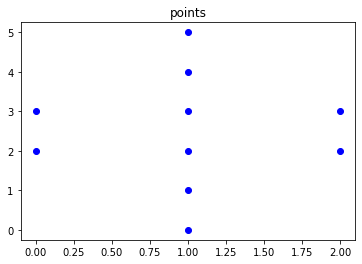

In [1033]:
plt.plot(pf.X,pf.Y,'bo')
plt.title('points')

In [1034]:
pf.iloc[0,:2]

X    1
Y    0
Name: 0, dtype: object

In [1035]:
d = {'Xb': [1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 2, 1], 
     'Yb': [0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4], 
     'Xe': [1, 0, 1, 2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1], 
     'Ye': [1, 2, 2, 2, 2, 3, 2, 3, 3, 3, 4, 3, 4, 4, 5],
     'Width': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
     'Name': ['OA','AB','AC','AD','BC','BE','CD','CF','DG','EF','EH','FG','FH','GH', 'HI']}
df = pd.DataFrame(data=d)
df

,Xb,Yb,Xe,Ye,Width,Name
0,1,0,1,1,1,OA
1,1,1,0,2,1,AB
2,1,1,1,2,1,AC
3,1,1,2,2,1,AD
4,0,2,1,2,1,BC
5,0,2,0,3,1,BE
6,1,2,2,2,1,CD
7,1,2,1,3,1,CF
8,2,2,2,3,1,DG
9,0,3,1,3,1,EF


Instead of having a bloated table, I will define here a few functions that could simply create the extra geometric properties of the network on demand.

In [1036]:
#Support geometry functions
def section_len(df):
    return ((df.Xe-df.Xb)**2+(df.Ye-df.Yb)**2)**0.5

def section_angle(df):
    return np.arctan((df.Ye-df.Yb)/(df.Xe-df.Xb))

In [1037]:
section_angle(df)

0     1.570796
1    -0.785398
2     1.570796
3     0.785398
4     0.000000
5     1.570796
6     0.000000
7     1.570796
8     1.570796
9     0.000000
10    0.785398
11    0.000000
12    1.570796
13   -0.785398
14    1.570796
dtype: float64

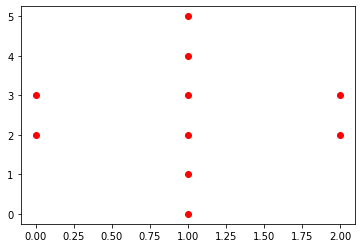

In [1038]:
plt.plot(pf.X,pf.Y, 'ro')

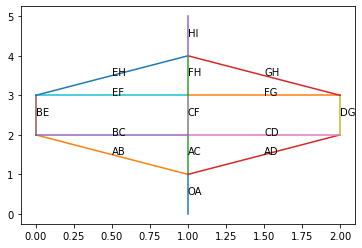

In [1039]:
plt.plot([df.Xb,df.Xe],[df.Yb,df.Ye])
for i in range(0,len(df)):
    plt.text((df.Xe[i]+df.Xb[i])*0.5,(df.Ye[i]+df.Yb[i])*0.5,str(df.Name[i]))

Create shorter segments

In [1040]:
dx = 0.1
L = section_len(df)
alpha = section_angle(df)
X_len = df.Xe-df.Xb 
Y_len = df.Ye-df.Yb
ids = 0

DFN_Mat2 = np.array([[],[],[],[],[],[],[]]).T
for i in range(0,len(df)):
    n_seg = np.floor(L[i]/dx)
    d_seg = L/n_seg

    for j in range(0,int(n_seg)):
        newline00 = int(ids)
        newline0 = df.Xb[i] + j*X_len[i]/n_seg
        newline1 = df.Yb[i] + j*Y_len[i]/n_seg
        newline2 = df.Xb[i] + (j+1)*X_len[i]/n_seg
        newline3 = df.Yb[i] + (j+1)*Y_len[i]/n_seg
        newline4 = df.Width[i]
        newline5 = df.Name[i]
        
        DFN_Mat2 = np.vstack([DFN_Mat2,[newline00,newline0,newline1,newline2,newline3,newline4,newline5]])
        ids = ids+1
        

sf = pd.DataFrame(DFN_Mat2, columns = ['id','Xb','Yb','Xe','Ye','Width','Name'])
sf.iloc[:,1:6] = sf.iloc[:,1:6].astype('float')

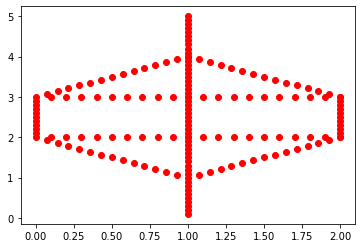

In [1041]:
plt.plot(sf.Xe,sf.Ye,'ro')

WEIR



In [1042]:
#sf.Xb[79] = sf.Xb[79]+0.1
#sf.Xe[79] = sf.Xe[79]+0.2
W = 1

sf.Xb[87] =  sf.Xb[87]+0.05*1

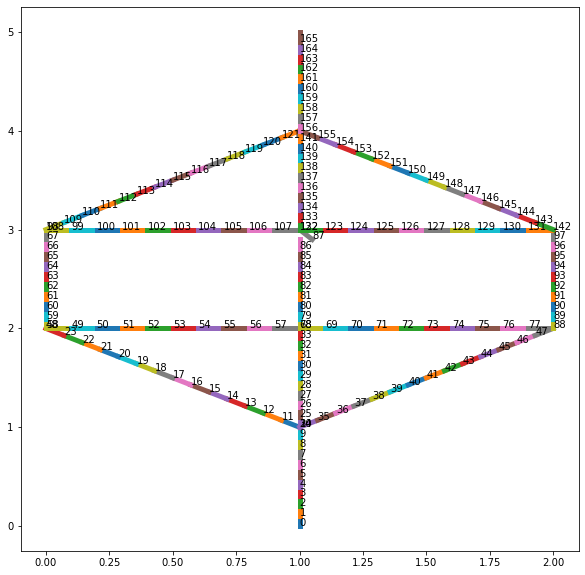

In [1043]:
plt.figure(figsize = [10,10])

for i in range(0,len(sf)):
    plt.plot([sf.Xb[i],sf.Xe[i]],[sf.Yb[i],sf.Ye[i]],lw=sf.Width[i]*5)
    plt.text(sf.Xb[i],sf.Yb[i],str(sf.id[i]))

We have to test different discretizations

## Connectivity matrix


The connectivity matrix explains which segment is connected to which other segments.

In [1044]:
eps = 0.001
Connect_Mat = np.ones([len(sf),6])*(-999) 


for i in range(0,len(sf)):
        D55 = abs(sf.Xb[:]-sf.Xb[i])
        D66 = abs(sf.Yb[:]-sf.Yb[i])
        D77 = abs(sf.Xe[:]-sf.Xe[i])
        D88 = abs(sf.Ye[:]-sf.Ye[i])
        D57 = abs(sf.Xe[:]-sf.Xb[i])
        D68 = abs(sf.Ye[:]-sf.Yb[i])
        D75 = abs(sf.Xb[:]-sf.Xe[i])
        D86 = abs(sf.Yb[:]-sf.Ye[i])
        
        index = np.where(((D55<=eps) & (D66<=eps)) | ((D77<=eps) & (D88<=eps)) | ((D57<= eps) & (D68<=eps)) | ((D75<=eps) & (D86<=eps)))
        k = 0
        for j in range(0,min(5,len(index[0]))):
            if (index[0][j]!=i):
                Connect_Mat[i,k] = index[0][j]
                k = k+1

In [1045]:
Connect_Mat[140:,:]

array([[ 139.,  141., -999., -999., -999., -999.],
       [ 121.,  140.,  155.,  156., -999., -999.],
       [  97.,  131.,  143., -999., -999., -999.],
       [ 142.,  144., -999., -999., -999., -999.],
       [ 143.,  145., -999., -999., -999., -999.],
       [ 144.,  146., -999., -999., -999., -999.],
       [ 145.,  147., -999., -999., -999., -999.],
       [ 146.,  148., -999., -999., -999., -999.],
       [ 147.,  149., -999., -999., -999., -999.],
       [ 148.,  150., -999., -999., -999., -999.],
       [ 149.,  151., -999., -999., -999., -999.],
       [ 150.,  152., -999., -999., -999., -999.],
       [ 151.,  153., -999., -999., -999., -999.],
       [ 152.,  154., -999., -999., -999., -999.],
       [ 153.,  155., -999., -999., -999., -999.],
       [ 121.,  141.,  154.,  156., -999., -999.],
       [ 121.,  141.,  155.,  157., -999., -999.],
       [ 156.,  158., -999., -999., -999., -999.],
       [ 157.,  159., -999., -999., -999., -999.],
       [ 158.,  160., -999., -9

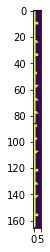

In [1046]:
plt.imshow(Connect_Mat!=-999)

Geometries are prepared, next come the 


## Physiscs part

Old parameters

In [1047]:
#Boundary conditions (pressure for now)
BC_coord = np.array(((-1,1,0),(1,1,5)))

P_Inj = 1     # Injection pressure [Pa]
P_Prod = 0    # Production pressure [Pa]
P_ini = 0    # Initial pressure in the fractures [Pa]


# +++++++++++++++ these need to be adjusted:
Dt_P = 10      # Pressure time step for steady state [sec]
DP_time = 10000
n_time_P = int(DP_time/Dt_P) # Maximum number of pressure time steps

num_Frac = len(sf)

AP = np.zeros([num_Frac,num_Frac])  # Init pressure conductivity Matrix(LHS)
BP = np.zeros(num_Frac)# Init pressure storativity Vector (RHS)



#Solve for steady-state pressure
tp = -1
#timeP = np.linspace(Dt_P,DP_time,n_time_P)

#P_new = [0]*num_Frac
BP = np.zeros(num_Frac)
APl = np.copy(AP)   #Local variable


Hydraulic parameters

These need to be adjusted for the surface water flow

In [1048]:
Gamma_P = np.zeros(num_Frac)
Gamma_P_tot = np.zeros(num_Frac)
Etha_P = np.zeros(num_Frac)

Ls = section_len(sf)
#A = 1 #aperture originally
V = 1 #viscosity originally
C = 1 # fluid compressibility originally


for i in range(0,num_Frac):
        Gamma_P[i] = Dt_P*sf.Width[i]**3/(6*V*Ls[i])   # Transmissivity 1
        Etha_P[i] = sf.Width[i]*C*Ls[i]                 # Storativity 1

In [1049]:
for i in range(0,num_Frac):
    Gamma_P_tot[i] = Gamma_P[i]
    for j in range(0,6):
        cn = int(Connect_Mat[i,j])
        if (cn >= 0):
            Gamma_P_tot[i] = Gamma_P_tot[i] + Gamma_P[cn]   # if and g1g2 based on index
            AP[i,cn] = Gamma_P[i]*Gamma_P[cn]
            AP[i,i] = AP[i,i]-Gamma_P[i]*Gamma_P[cn]
    AP[i,i] = AP[i,i]/Gamma_P_tot[i] - Etha_P[i]
    for j in range(0,6):
        cn = int(Connect_Mat[i,j])
        if (cn >= 0):
            AP[i,cn] = AP[i,cn]/Gamma_P_tot[i]

In [1050]:
AP

array([[ -8.43333333,   8.33333333,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  5.55555556, -11.21111111,   5.55555556, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   5.55555556, -11.21111111, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., -11.21111111,
          5.55555556,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   5.55555556,
        -11.21111111,   5.55555556],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          8.33333333,  -8.43333333]])

In [1051]:
 # Solve Finite Difference pressure
P_old = np.ones(num_Frac)
P_new = np.zeros([n_time_P,num_Frac])    

tp = -1
while (tp < n_time_P-1):
    tp = tp + 1

    #Apply initial conditions
    if (tp==0):
        P_old = P_old*P_ini     # Initial pressure
    else:
        P_old[0:num_Frac] = P_new[tp-1,:]

#            for i in range(0,num_Frac):
#                BP[i] = -Etha_P[i]*P_old[i]
    BP = -Etha_P*P_old

    # Apply boundary conditions
    APl[0,:] = 0                      #ASK REZA - does not do a lot
    APl[0,0] = 1
    BP[0] = P_Inj
    
    APl[len(sf)-1,:] = 0
    APl[len(sf)-1,len(sf)-1] = 1
    BP[len(sf)-1] = P_Prod
    
    # Injection points
    #APl[int(Inj_id[idinj]),:] = 0
    #APl[int(Inj_id[idinj]),int(Inj_id[idinj])] = 1
    #BP[int(Inj_id[idinj])] = P_Inj
    
    #Production points
#        for i in range(0,np.shape(Prod_id)[0]):
#            APl[int(Prod_id[i]),:] = 0
#            APl[int(Prod_id[i]),int(Prod_id[i])] = 1
#            BP[int(Prod_id[i])] = P_Prod

    # Solver for pressure
    #AP2 =  #SPARSE MATRIX NEEDED for performance
    AP2 = scipy.sparse.csc_matrix(APl)

    P_new[tp,:] = scipy.linalg.solve(AP,BP.T) #standard solution
    #P_new[tp,:] = scipy.sparse.linalg.spsolve(AP2,BP.T,permc_spec='MMD_ATA') #Fastest but can be singular
    #P_new[tp,:] = scipy.linalg.lstsq(AP,BP.T)[0] #numerical approx
    
tss = tp

P_new = P_new[0:tss+1,:]

Plots for pressure

In [1052]:
P_new

array([[-7.95975628e-01, -6.85527335e-01, -5.87418535e-01, ...,
        -2.26575265e-04, -2.20006379e-04, -2.17397607e-04],
       [-1.05070622e+00, -9.43314697e-01, -8.40563344e-01, ...,
        -1.20573062e-03, -1.17461930e-03, -1.16069101e-03],
       [-1.19080497e+00, -1.08509463e+00, -9.81936329e-01, ...,
        -3.58978744e-03, -3.50624223e-03, -3.46466624e-03],
       ...,
       [-5.81359841e+00, -5.76336159e+00, -5.71312549e+00, ...,
        -4.27483314e+00, -4.22473673e+00, -4.17464104e+00],
       [-5.81363742e+00, -5.76340107e+00, -5.71316543e+00, ...,
        -4.27487293e+00, -4.22477606e+00, -4.17467990e+00],
       [-5.81367618e+00, -5.76344029e+00, -5.71320511e+00, ...,
        -4.27491246e+00, -4.22481513e+00, -4.17471851e+00]])

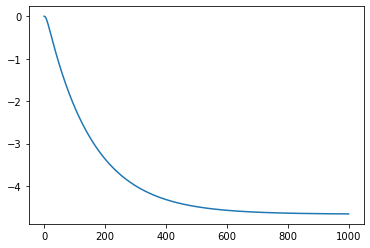

In [1053]:
plt.plot(P_new[:,140])

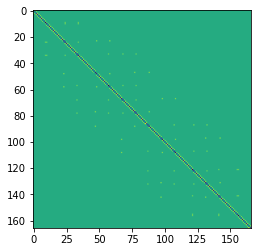

In [1054]:
plt.imshow(AP)

C:\Users\Mark\AppData\Local\Temp/ipykernel_2396/2113599058.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(CS3)


<Figure size 432x288 with 0 Axes>

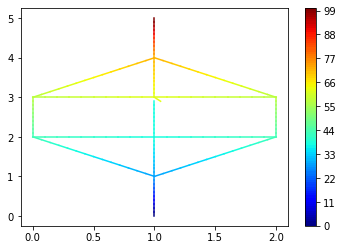

In [1055]:
time = 999
P_norm = (P_new[time,:]-min(P_new[time,:]))/(max(P_new[time,:])-min(P_new[time,:]))
cmap = matplotlib.cm.get_cmap('jet')

Z = [[0,0],[0,0]]
levels = range(0,101,1)
CS3 = plt.contourf(Z, levels, cmap=cmap)
plt.clf()


fig = plt.figure()
for i in range(0,len(sf)):
    plot = plt.plot([sf.Xb[i],sf.Xe[i]],[sf.Yb[i],sf.Ye[i]],color=cmap(P_norm[i]))

    

plt.colorbar(CS3)

Calculate velocities next
(I am not sure if this is going to be needed in the end)

In [1056]:
#Estimate velocity
num_up = np.zeros(num_Frac)
V = np.zeros(num_Frac)
for i in range(0,num_Frac):
    P_Max = P_new[tss,i]
    num_up[i] = i
    for j in range(0,6):
        cn = int(Connect_Mat[i,j])
        if (cn >= 0 and P_new[tp,cn] > P_Max):
            P_Max = P_new[tp,cn]
            num_up[i] = cn

        V[i] = 1**2/(12*1*2)*(P_Max-P_new[tp,i])


Plotting out velocity distribution

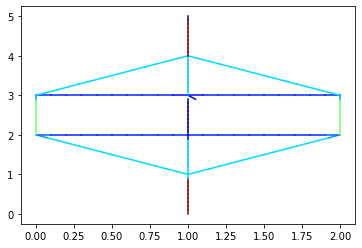

In [1059]:
V_norm = (V-min(V))/(max(V)-min(V))
cmap = matplotlib.cm.get_cmap('jet')

for i in range(0,len(sf)):
    plt.plot([sf.Xb[i],sf.Xe[i]],[sf.Yb[i],sf.Ye[i]],color=cmap(V_norm[i]))
    
#plt.plot([sf.Xb,sf.Xe],[sf.Yb,sf.Ye],color=cmap(V_norm))
    

SOmething like discharge

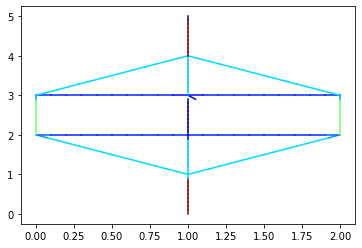

In [1060]:
V2 = V*sf.Width*1
V2_norm = (V2-min(V2))/(max(V2)-min(V2))
cmap = matplotlib.cm.get_cmap('jet')

for i in range(0,len(sf)):
    plt.plot([sf.Xb[i],sf.Xe[i]],[sf.Yb[i],sf.Ye[i]],color=cmap(V2_norm[i]))
    
#plt.plot([sf.Xb,sf.Xe],[sf.Yb,sf.Ye],color=cmap(V_norm))
    

Summary figure

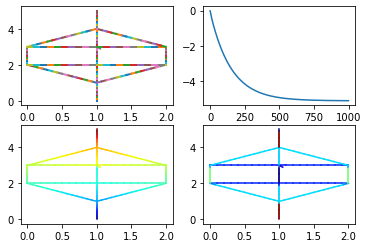

In [1065]:
plt.subplot(2,2,1)
for i in range(0,len(sf)):
    plt.plot([sf.Xb[i],sf.Xe[i]],[sf.Yb[i],sf.Ye[i]],lw=sf.Width[i]*2)
    #plt.text(sf.Xb[i],sf.Yb[i],str(sf.id[i]))
    
    
plt.subplot(2,2,2)
plt.plot(P_new[:,23])

plt.subplot(2,2,3)
time = 999
P_norm = (P_new[time,:]-min(P_new[time,:]))/(max(P_new[time,:])-min(P_new[time,:]))
cmap = matplotlib.cm.get_cmap('jet')

for i in range(0,len(sf)):
    plot = plt.plot([sf.Xb[i],sf.Xe[i]],[sf.Yb[i],sf.Ye[i]],color=cmap(P_norm[i]))
    
    
plt.subplot(2,2,4)
V2 = V*sf.Width*1
V2_norm = (V2-min(V2))/(max(V2)-min(V2))
cmap = matplotlib.cm.get_cmap('jet')

for i in range(0,len(sf)):
    plt.plot([sf.Xb[i],sf.Xe[i]],[sf.Yb[i],sf.Ye[i]],color=cmap(V2_norm[i]))